In [13]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.applications.mobilenet_v2 import MobileNetV2

from IPython.display import HTML
from base64 import b64encode

In [2]:
NonViolnceVideos_Dir = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/"
ViolnceVideos_Dir = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/"

In [3]:
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

In [4]:
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [5]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16

In [6]:
DATASET_DIR = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/"

In [7]:
CLASSES_LIST = ["NonViolence", "Violence"]

In [8]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [9]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [10]:
features, labels, video_files_paths = create_dataset()
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

Extracting Data of Class: NonViolence


[h264 @ 0x5a1963e5c5c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a1963e5c5c0] error while decoding MB 98 31
[h264 @ 0x5a1974322b00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a1974322b00] error while decoding MB 98 31
[h264 @ 0x5a1974322b00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a1974322b00] error while decoding MB 98 31
[h264 @ 0x5a1974322b00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a1974322b00] error while decoding MB 98 31
[h264 @ 0x5a1974322b00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5a1974322b00] error while decoding MB 98 31


Extracting Data of Class: Violence


In [11]:
features, labels, video_files_paths = np.load("features.npy"), np.load("labels.npy"), np.load("video_files_paths.npy")

In [14]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.1,
                                                                            shuffle=True, random_state=42)

In [15]:
print(features_train.shape, labels_train.shape)
print(features_test.shape, labels_test.shape)

(1800, 16, 64, 64, 3) (1800, 2)
(200, 16, 64, 64, 3) (200, 2)


In [16]:
# mobilenet = MobileNetV2(include_top=False, weights="imagenet")
# mobilenet.trainable = True

2024-03-18 16:26:37.830356: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-03-18 16:26:37.830501: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-03-18 16:26:37.830604: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-03-18 16:26:37.830684: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-03-18 16:26:37.830756: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-03-18 16:26:37.830965: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-03-18 16:26:37.831064: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
# for layer in mobilenet.layers[:-40]:
#     layer.trainable = False

In [47]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards=True)
    model.add(Bidirectional(lstm_fw, backward_layer=lstm_bw))
    model.add(Dropout(0.25))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()
    return model

In [48]:
MoBiLSTM_model = create_model()
plot_model(MoBiLSTM_model, to_file='MobBiLSTM_model_structure_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 16, 2, 2, 1280)    2257984   
 stributed)                                                      
                                                                 
 dropout_14 (Dropout)        (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_5 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                1319168   
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                      

In [49]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.00005, verbose=1)

In [50]:
MoBiLSTM_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])
MobBiLSTM_model_history = MoBiLSTM_model.fit(x=features_train, y=labels_train, epochs=40, batch_size=8,
                                             shuffle=True, validation_split=0.2,
                                             callbacks=[early_stopping_callback, reduce_lr])


Epoch 1/40
180/180 [==============================] - 43s 199ms/step - loss: 0.6415 - accuracy: 0.6194 - val_loss: 0.4107 - val_accuracy: 0.9139 - lr: 0.0100
Epoch 2/40
180/180 [==============================] - 33s 184ms/step - loss: 0.2658 - accuracy: 0.9375 - val_loss: 0.2882 - val_accuracy: 0.9028 - lr: 0.0100
Epoch 3/40
180/180 [==============================] - 32s 180ms/step - loss: 0.1570 - accuracy: 0.9486 - val_loss: 0.2853 - val_accuracy: 0.9111 - lr: 0.0100
Epoch 4/40
180/180 [==============================] - 33s 183ms/step - loss: 0.1344 - accuracy: 0.9556 - val_loss: 0.3110 - val_accuracy: 0.9306 - lr: 0.0100
Epoch 5/40
180/180 [==============================] - 33s 184ms/step - loss: 0.1247 - accuracy: 0.9681 - val_loss: 0.7037 - val_accuracy: 0.8417 - lr: 0.0100
Epoch 6/40
180/180 [==============================] - 32s 181ms/step - loss: 0.1041 - accuracy: 0.9708 - val_loss: 0.3760 - val_accuracy: 0.9083 - lr: 0.0100
Epoch 7/40
180/180 [==============================] 

In [51]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

7/7 [==============================] - 4s 314ms/step - loss: 0.1081 - accuracy: 0.9700


In [52]:
MoBiLSTM_model.save("Violance_Detection_Task-1.h5")

/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
labels_predict = MoBiLSTM_model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

7/7 [==============================] - 4s 311ms/step



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


[Text(0, 0.5, 'NonViolence'), Text(0, 1.5, 'Violence')]

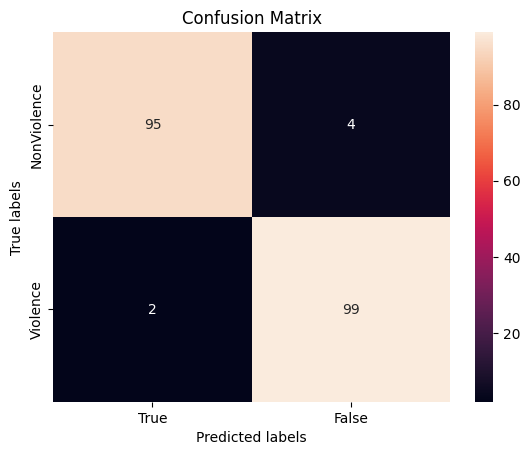

In [54]:
!pip install seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

In [55]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal, labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        99
           1       0.96      0.98      0.97       101

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

